In [1]:
import numpy as np
import networkx as nx
from scipy.stats import powerlaw
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline


In [2]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 22
plt.rc('font', size=SMALL_SIZE, family = "Nimbus Roman")          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
class DegreeCorrectedSBM:
    def __init__(self, sizes, P, theta_distribution="powerlaw", alpha=2.5, seed=None):
        """
        Initializes a Degree-Corrected Stochastic Block Model (DCSBM).
        
        Parameters:
        - sizes: List of community sizes.
        - P: Block probability matrix (KxK) controlling inter/intra-community edge probabilities.
        - theta_distribution: Distribution for degree correction ("powerlaw", "uniform", "degree").
        - alpha: Power-law exponent (for "powerlaw" case).
        - seed: Random seed for reproducibility.
        """
        self.sizes = sizes
        self.P = np.array(P)
        self.K = len(sizes)  # Number of communities
        self.n = sum(sizes)  # Total nodes
        self.theta_distribution = theta_distribution
        self.alpha = alpha
        self.seed = np.random.default_rng(seed)
        self.community_labels = np.concatenate([[k] * sizes[k] for k in range(self.K)])
        
    def generate_theta(self):
        """Generates degree correction factors theta_i for all nodes."""
        if self.theta_distribution == "powerlaw":
            theta = powerlaw.rvs(self.alpha, size=self.n, random_state=self.seed)
        elif self.theta_distribution == "uniform":
            theta = self.seed.uniform(0.5, 1.5, self.n)
        else:
            theta = np.ones(self.n)  # No degree correction (reduces to SBM)
        
        # Normalize within each community
        for k in range(self.K):
            mask = self.community_labels == k
            theta[mask] /= theta[mask].sum()
            
        print(f"Min Theta: {np.min(theta)} \t Max Theta: {np.max(theta)} \t Average Theta: {np.mean(theta)}")
        return theta
    
    def generate_graph(self):
        """Generates a graph using the Degree-Corrected SBM."""
        theta = self.generate_theta()
        G = nx.Graph()
        
        # Add nodes with community labels
        for i in range(self.n):
            G.add_node(i, community=self.community_labels[i], theta=theta[i])
        
        # Generate edges based on theta and P
        for i in range(self.n):
            for j in range(i + 1, self.n):
                k_i, k_j = self.community_labels[i], self.community_labels[j]
                prob = theta[i] * theta[j] * self.P[k_i, k_j]
                if self.seed.uniform() < prob:
                    G.add_edge(i, j)
        
        return G

[[200. 100.]
 [100. 200.]]
Min Theta: 0.0027584177925854994 	 Max Theta: 0.031529611369840504 	 Average Theta: 0.019999999999999997


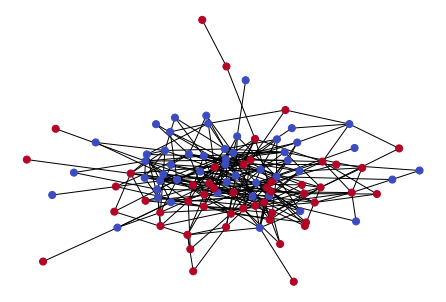

In [7]:
# Example Usage
b = 50
sizes = [b, b]  # Two communities with 50 nodes each
P = [[0.08, 0.04],  # Intra-community probability (0.1), inter-community (0.02)
     [0.04, 0.08]]
P = np.array(P)
P *= b**2
print(P)

dcsbm = DegreeCorrectedSBM(sizes, P, theta_distribution="powerlaw", alpha=2, seed=42)
G = dcsbm.generate_graph()

# Visualize the graph (optional)
nx.draw(G, node_color=[G.nodes[i]['community'] for i in G.nodes], node_size=50, cmap='coolwarm')


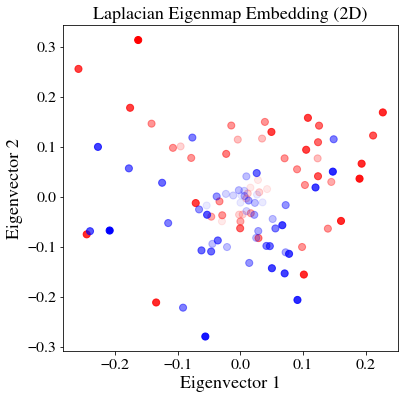

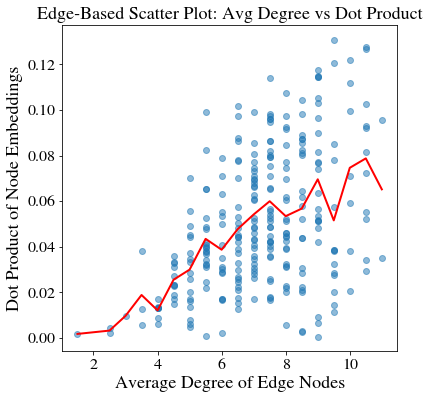

In [12]:
# Compute the Random-Walk Laplacian
n = len(G)
A = nx.to_numpy_array(G)
D = np.diag(A.sum(axis=1))

tau = 100
D_tau = D + tau * np.eye(n)
L_norm = np.eye(n) - np.linalg.inv(np.sqrt(D_tau)) @ A @ np.linalg.inv(np.sqrt(D_tau))

# Compute the two smallest non-trivial eigenvectors for embedding
vals, vecs = eigsh(L_norm, k=8, which='SM')
# print(vals)
embedding = vecs[:, 1:]

# embedding norm by popularity 

def get_colors(G):
    # Compute node degrees for transparency mapping
    degrees = np.array([G.degree[i] for i in G.nodes])
    max_degree = degrees.max() if degrees.max() > 0 else 1
    alphas = degrees / max_degree  # Normalize degrees between 0 and 1

    colors = []
    for idx, node in enumerate(G.nodes):
        label = G.nodes[node]["community"]
        c = (int(label == 0), 0, int(label == 1), alphas[idx])
        colors.append(c)
    return colors

# Plot the Laplacian Eigenmap embedding
plt.figure(figsize=(6, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], 
            c=get_colors(G),
            cmap='coolwarm', s=50)
plt.xlabel("Eigenvector 1")
plt.ylabel("Eigenvector 2")
plt.title("Laplacian Eigenmap Embedding (2D)")
plt.show()

# Scatter plot of edges with average degree vs dot product of embeddings
edge_avg_degrees = []
edge_dot_products = []

for u, v in G.edges():
    avg_degree = (G.degree[u] + G.degree[v]) / 2
    dot_product = np.dot(embedding[u], embedding[v])
    edge_avg_degrees.append(avg_degree)
    edge_dot_products.append(dot_product)

plt.figure(figsize=(6, 6))
plt.scatter(edge_avg_degrees, edge_dot_products, alpha=0.5)

# Compute average y values for each x value
unique_x = np.unique(edge_avg_degrees)
mean_y = [np.mean([edge_dot_products[i] for i in range(len(edge_avg_degrees)) if edge_avg_degrees[i] == x]) for x in unique_x]

# Smooth curve using interpolation
spline = make_interp_spline(unique_x, mean_y, k=3)
x_smooth = np.linspace(min(unique_x), max(unique_x), 300)
y_smooth = spline(x_smooth)

plt.plot(unique_x, mean_y, color='red', linewidth=2, label="Average Trend")

plt.xlabel("Average Degree of Edge Nodes")
plt.ylabel("Dot Product of Node Embeddings")
plt.title("Edge-Based Scatter Plot: Avg Degree vs Dot Product")
plt.show()


# RSC vs BPR for DC-SBM